In [77]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn import tree
import sklearn.metrics as metrics
import scikitplot as skplt
from sklearn.metrics import classification_report
from math import sqrt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, \
                            precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, SVR
import tensorflow as tf
from keras.models import Sequential
from keras.regularizers import l2
from kerastuner.tuners import RandomSearch
from keras.layers import Dense, Dropout
import seaborn as sns
import warnings
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.datasets import load_breast_cancer
from xgboost import XGBClassifier, XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, AdaBoostClassifier,GradientBoostingClassifier
import time
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
from xgboost import XGBClassifier

In [3]:
data =pd.read_excel('C:\\Users\\saiak\\Downloads\\MSBA\\Fall Semester ( Semester 2 )\\Predictive Analytics\\HWs\\HW3.xlsx')

In [4]:
x=data.drop('sequence_number', axis = 1).iloc[:,:-2].values
y1=data.iloc[:,-1].values # Spending
y2=data.iloc[:,-2].values # Purchase

In [5]:
x_train,x_test,y_train,y_test = train_test_split(x,y1,test_size = 0.2, random_state = 42)

In [6]:
mm_scaler = MinMaxScaler()
x_full_trans = mm_scaler.fit_transform(x)
x_train_trans = mm_scaler.fit_transform(x_train)
x_test_trans = mm_scaler.transform(x_test)

In [23]:
data.head()

,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,source_x,source_w,Freq,last_update_days_ago,1st_update_days_ago,Web order,Gender=male,Address_is_res,Purchase,Spending
0,1,1,0,0,1,0,0,0,0,0,...,0,0,2,3662,3662,1,0,1,1,127.87
1,2,1,0,0,0,0,1,0,0,0,...,0,0,0,2900,2900,1,1,0,0,0.00
2,3,1,0,0,0,0,0,0,0,0,...,0,0,2,3883,3914,0,0,0,1,127.48
3,4,1,0,1,0,0,0,0,0,0,...,0,0,1,829,829,0,1,0,0,0.00
4,5,1,0,1,0,0,0,0,0,0,...,0,0,1,869,869,0,0,0,0,0.00


# Question 1a

In [24]:
start = time.process_time()
nested_scores = np.zeros(6)
non_nested_scores = np.zeros(6)
classifiers = [RandomForestRegressor(), XGBRegressor(), DecisionTreeRegressor(), KNeighborsRegressor(), SVR(), \
               LinearRegression()]
models_param_grid = [
    {
        'RandomForest__bootstrap': [True, False],
         'RandomForest__max_depth': [10, 20, 30, 40, 50,100, 200, None], # 60, 70, 80, 90,
         'RandomForest__max_features': ['auto', 'sqrt'],
         'RandomForest__min_samples_leaf': [1, 2, 4],
         'RandomForest__min_samples_split': [2, 5, 10],
         'RandomForest__n_estimators': [200, 400, 600, 800, 1000] # 1200, 1400, 1600, 1800, 2000
    }
    ,
    {
        'XGBoost__learning_rate' : [0.01,0.05,0.10,0.20,0.30, 0.50],
        'XGBoost__max_depth'     : [1,2,3,4,5,7,10,15],
        'XGBoost__min_child_weight': [1, 3, 5, 7],
        'XGBoost__gamma'         : [0.01, 0.1, 0.2, 0.3, 0.4],
        "XGBoost__n_estimators": [100, 250, 500, 1000],
        "XGBoost__colsample_bytree": [0.3, 0.6, 0.8, 1.0],
        "XGBoost__reg_alpha": [0, 0.5, 1],
        "XGBoost__reg_lambda": [1, 1.5, 2, 3, 4.5]
    },
    {
        "DecisionTree__criterion": ["mse", "mae"],
        "DecisionTree__min_samples_split": [5, 10, 20, 40],
        "DecisionTree__max_depth": [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 15, 20],
        "DecisionTree__min_samples_leaf": [10, 20, 40, 100],
        "DecisionTree__max_leaf_nodes": [5, 20, 100]              
    },
    {
        'KNN__n_neighbors': range(1,50),
        'KNN__weights': ['uniform', 'distance']
    },
    {
        'SVR__C':[0.1, 1, 10, 100, 1000],
         'SVR__gamma':[1, 0.1, 0.01, 0.001, 0.0001],
         'SVR__kernel':['rbf']
    },
    {
        'LinearRegresison__fit_intercept' : [True, False]        
    }]
model_names = ['RandomForest','XGBoost','DecisionTree', 'KNN', 'SVR','LinearRegresison']
model_performance = {}
model_confusion_matrix = {}
for i,model in enumerate(classifiers):
    
    pipe = Pipeline([('MinMaxScaler',MinMaxScaler()),(model_names[i],model)])
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = RandomizedSearchCV(estimator=pipe, param_distributions=models_param_grid[i], cv=inner_cv, n_jobs = -1, scoring='neg_mean_absolute_error')
#     clf.fit(x_full_trans, y1)
#     non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=x_train_trans, y=y_train, cv=outer_cv, scoring = 'neg_mean_absolute_error') #
    nested_scores[i] = nested_score.mean()
    print('Model: ', model_names[i],' Nested Score: ', abs(nested_scores[i])) # sqrt(abs(nested_scores[i]))
    model_performance[model_names[i]] = abs(nested_scores[i])

print('Time Taken = ', time.process_time() - start)

Model:  RandomForest  Nested Score:  67.47694880762563
[00:01:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model:  XGBoost  Nested Score:  71.89466405705214
Model:  DecisionTree  Nested Score:  70.92294687500001
Model:  KNN  Nested Score:  87.30156328423766
Model:  SVR  Nested Score:  74.41689851910401
Model:  LinearRegresison  Nested Score:  77.50452606416457
Time Taken =  14.703125


In [148]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [ ]:
# Since RandomForestRegressor is the best in terms of MAE, we select RandomForestRegressor as the best model and see the
# performance on the test dataset



In [49]:
# Using Neural Network with Back Propagation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline


from keras.layers import Dense
def build_regressor():
    regressor = Sequential()
    regressor.add(Dense(units=200, activation = 'relu', input_dim=22,kernel_regularizer = l2(0.01)))
#     regressor.add(Dropout(0.3,noise_shape = None, seed= None))
    regressor.add(Dense(units=200, activation = 'relu', input_dim=22, kernel_regularizer = l2(0.01)))
#     regressor.add(Dropout(0.3,noise_shape = None, seed= None))
#     regressor.add(Dense(units=200, input_dim=22, kernel_regularizer = l2(0.01)))
#     regressor.add(Dropout(0.3,noise_shape = None, seed= None))
    regressor.add(Dense(units=1))
    regressor.compile(optimizer='adam', loss='mean_absolute_error',  metrics=['mae','accuracy','mse'])
    return regressor



from keras.wrappers.scikit_learn import KerasRegressor
regressor = KerasRegressor(build_fn=build_regressor, batch_size=59,epochs=100)    

model = regressor.fit(x_train_trans, y_train, epochs=50)

pred_train= regressor.predict(x_train_trans)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred= regressor.predict(x_test_trans)
print(np.sqrt(mean_squared_error(y_test,pred))) 

Epoch 1/50
1600/1600 [==============================] - ETA: 4s - loss: 90.8034 - mae: 88.4041 - accuracy: 0.2881 - mse: 21339.57 - ETA: 0s - loss: 106.0825 - mae: 104.0049 - accuracy: 0.1665 - mse: 45297.39 - 0s 171us/step - loss: 103.0064 - mae: 101.1193 - accuracy: 0.1619 - mse: 44347.0039
Epoch 2/50
1600/1600 [==============================] - ETA: 0s - loss: 139.4051 - mae: 138.0386 - accuracy: 0.1356 - mse: 83207.89 - ETA: 0s - loss: 106.2983 - mae: 105.1052 - accuracy: 0.1141 - mse: 48747.66 - 0s 63us/step - loss: 101.9243 - mae: 100.8485 - accuracy: 0.0969 - mse: 44129.7461
Epoch 3/50
1600/1600 [==============================] - ETA: 0s - loss: 112.4127 - mae: 111.5827 - accuracy: 0.1525 - mse: 49362.53 - ETA: 0s - loss: 92.8876 - mae: 92.1344 - accuracy: 0.0883 - mse: 35832.2812 - 0s 51us/step - loss: 100.6680 - mae: 99.9315 - accuracy: 0.0756 - mse: 43341.0000
Epoch 4/50
1600/1600 [==============================] - ETA: 0s - loss: 106.4281 - mae: 105.7214 - accuracy: 0.0000e+

1600/1600 [==============================] - ETA: 0s - loss: 71.2662 - mae: 66.7271 - accuracy: 0.0000e+00 - mse: 9750.241 - ETA: 0s - loss: 72.8072 - mae: 68.2779 - accuracy: 0.0130 - mse: 17539.0762  - 0s 65us/step - loss: 72.7688 - mae: 68.2490 - accuracy: 0.0106 - mse: 18554.8320
Epoch 29/50
1600/1600 [==============================] - ETA: 0s - loss: 66.7278 - mae: 62.2446 - accuracy: 0.0847 - mse: 7940.523 - ETA: 0s - loss: 73.1512 - mae: 68.7415 - accuracy: 0.0188 - mse: 20065.64 - 0s 53us/step - loss: 72.5652 - mae: 68.1763 - accuracy: 0.0206 - mse: 18981.9492
Epoch 30/50
1600/1600 [==============================] - ETA: 0s - loss: 54.4120 - mae: 50.0328 - accuracy: 0.0000e+00 - mse: 7207.880 - ETA: 0s - loss: 72.6752 - mae: 68.2552 - accuracy: 0.0178 - mse: 17695.0273  - 0s 49us/step - loss: 72.5209 - mae: 68.1000 - accuracy: 0.0150 - mse: 18540.5098
Epoch 31/50
1600/1600 [==============================] - ETA: 0s - loss: 75.1076 - mae: 70.7095 - accuracy: 0.0169 - mse: 9655.9

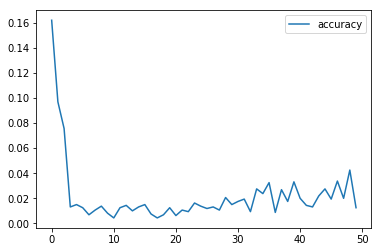

In [53]:
# Accuracy plot
plt.plot(model.history['accuracy'],label = 'accuracy')
plt.legend()
# plt.plot(history.history['cosine_proximity'])
plt.show()

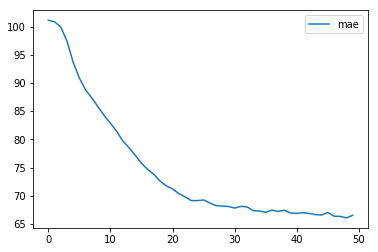

In [51]:
# Mean Absolute Error Plot
plt.plot(model.history['mae'], label = 'mae')
plt.legend()
# plt.plot(history.history['cosine_proximity'])
plt.show()

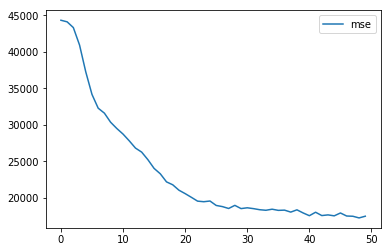

In [52]:
# Mean Squared Error Plot
plt.plot(model.history['mse'], label = 'mse')
plt.legend()
# plt.plot(history.history['cosine_proximity'])
plt.show()

# Question 1b

In [151]:
x_new = data[data['Purchase'] ==1].drop('sequence_number', axis = 1).iloc[:,:-2].values
y =  data[data['Purchase'] ==1].iloc[:,-1].values
mm_scaler = MinMaxScaler()
x_new_trans = mm_scaler.fit_transform(x_new)
x_train,x_test,y_train,y_test = train_test_split(x_new,y,test_size = 0.2, random_state = 42)

In [54]:
start = time.process_time()
nested_scores = np.zeros(6)
non_nested_scores = np.zeros(6)
classifiers = [RandomForestRegressor(), XGBRegressor(), DecisionTreeRegressor(), KNeighborsRegressor(), SVR(), \
               LinearRegression()]
models_param_grid = [
    {
        'RandomForest__bootstrap': [True, False],
         'RandomForest__max_depth': [10, 20, 30, 40, 50, 100, 200, None], # 60, 70, 80, 90,
         'RandomForest__max_features': ['auto', 'sqrt'],
         'RandomForest__min_samples_leaf': [1, 2, 4, 8],
         'RandomForest__min_samples_split': [2, 5, 10, 15, 20],
         'RandomForest__n_estimators': [200, 400, 600, 800, 1000] # 1200, 1400, 1600, 1800, 2000
    }
    ,
    {
        'XGBoost__learning_rate' : [0.01,0.05,0.10,0.20,0.30, 0.50],
        'XGBoost__max_depth'     : [1,2,3,4,5,7,10,15, 30, 50],
        'XGBoost__min_child_weight': [1, 3, 5, 7],
        'XGBoost__gamma'         : [0.01, 0.1, 0.2, 0.3, 0.4],
        "XGBoost__n_estimators": [100, 250, 500, 1000],
        "XGBoost__colsample_bytree": [0.3, 0.6, 0.8, 1.0],
        "XGBoost__reg_alpha": [0, 0.5, 1],
        "XGBoost__reg_lambda": [1, 1.5, 2, 3, 4.5]
    },
    {
        "DecisionTree__criterion": ["mse", "mae"],
        "DecisionTree__min_samples_split": [10, 20, 40],
        "DecisionTree__max_depth": [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 15, 20],
        "DecisionTree__min_samples_leaf": [5, 10, 20, 40, 100],
        "DecisionTree__max_leaf_nodes": [5, 20, 100]              
    },
    {
        'KNN__n_neighbors': range(1,30),
        'KNN__weights': ['uniform', 'distance']
    },
    {
        'SVR__C':[0.1, 1, 10, 100, 1000],
         'SVR__gamma':[1, 0.1, 0.01, 0.001, 0.0001],
         'SVR__kernel':['rbf']
    },
    {
        'LinearRegresison__fit_intercept' : [True, False]        
    }]
model_names = ['RandomForest','XGBoost','DecisionTree', 'KNN', 'SVR','LinearRegresison']
model_performance = {}
model_confusion_matrix = {}
for i,model in enumerate(classifiers):
    
    pipe = Pipeline([('MinMaxScaler',MinMaxScaler()),(model_names[i],model)])
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = RandomizedSearchCV(estimator=pipe, param_distributions=models_param_grid[i], cv=inner_cv, n_jobs = -1, scoring='neg_mean_absolute_error')
#     clf.fit(x_full_trans, y1)
#     non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=x_train_trans, y=y_train, cv=outer_cv, scoring = 'neg_mean_absolute_error')
    nested_scores[i] = nested_score.mean()
    print('Model: ', model_names[i],' Nested Score: ', abs(nested_scores[i]))
    model_performance[model_names[i]] = abs(nested_scores[i])

print('Time Taken = ', time.process_time() - start)

Model:  RandomForest  Nested Score:  67.55263798136419
[00:32:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:33:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model:  XGBoost  Nested Score:  69.07084507141487
Model:  DecisionTree  Nested Score:  74.42789799474549
Model:  KNN  Nested Score:  87.62879044538124
Model:  SVR  Nested Score:  71.42515147493022
Model:  LinearRegresison  Nested Score:  77.50452606416457
Time Taken =  16.046875


# Problem 2

In [58]:
names = ["word_freq_make","word_freq_address","word_freq_all",
"word_freq_3d","word_freq_our","word_freq_over","word_freq_remove","word_freq_internet","word_freq_order","word_freq_mail",
"word_freq_receive","word_freq_will","word_freq_people","word_freq_report","word_freq_addresses","word_freq_free","word_freq_business",
"word_freq_email","word_freq_you","word_freq_credit","word_freq_your","word_freq_font","word_freq_000","word_freq_money",
"word_freq_hp","word_freq_hpl","word_freq_george","word_freq_650","word_freq_lab","word_freq_labs","word_freq_telnet",
"word_freq_857","word_freq_data","word_freq_415","word_freq_85","word_freq_technology","word_freq_1999","word_freq_parts",
"word_freq_pm","word_freq_direct","word_freq_cs","word_freq_meeting","word_freq_original","word_freq_project","word_freq_re",
"word_freq_edu","word_freq_table","word_freq_conference","char_freq_;","char_freq_(","char_freq_[","char_freq_!","char_freq_$",
"char_freq_#","capital_run_length_average","capital_run_length_longest","capital_run_length_total","class"
]

In [64]:
data = pd.read_csv('C:\\Users\\saiak\\Downloads\\MSBA\\Fall Semester ( Semester 2 )\\Predictive Analytics\\HWs\\HW 3\\spambase.data'\
                  , names = names)
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values
mm_scaler = MinMaxScaler()
x_full_trans = mm_scaler.fit_transform(x)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 42)
x_train_trans = mm_scaler.fit_transform(x_train)
x_test_trans = mm_scaler.transform(x_test)

In [63]:
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


# Neural Net with Back Propagation

In [66]:
from tensorflow.python import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from kerastuner.tuners import RandomSearch

model = Sequential()
n_cols = x_train.shape[1]
model.add(Dense(200, activation = 'relu', input_dim=57,kernel_regularizer = l2(0.01)))
# model.add(Dropout(0.3,noise_shape = None, seed= None))
model.add(Dense(200, activation = 'relu', kernel_regularizer = l2(0.01)))
# model.add(Dropout(0.3,noise_shape = None, seed= None))
model.add(Dense(200, activation = 'relu', kernel_regularizer = l2(0.01)))
# model.add(Dropout(0.3,noise_shape = None, seed= None))
model.add(Dense(200, activation = 'relu', kernel_regularizer = l2(0.01)))
# model.add(Dropout(0.3,noise_shape = None, seed= None))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.fit(x_train_trans,y_train,epochs=200)

accuracy = model.evaluate(x_test_trans, y_test)
print(accuracy)

921/921 [==============================] - ETA:  - 0s 93us/step
[0.2694254766069717, 0.929424524307251]


# Using nested cross validation, determine best model

In [68]:
# Using Nested Cross Validation to Compare Performance of Various Models
start = time.process_time()
nested_scores = np.zeros(4)
non_nested_scores = np.zeros(4)
classifiers = [RandomForestClassifier(), XGBClassifier(), KNeighborsClassifier(), LogisticRegression()] # , SVC(probability=True)
models_param_grid = [
    {
        'bootstrap': [True, False],
         'max_depth': [10, 20, 30, 40, 50,  100, None], # 60, 70, 80, 90,
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400, 600, 800, 1000] # 1200, 1400, 1600, 1800, 2000
    }
    ,
    {
        'learning_rate' : [0.01,0.05,0.10,0.20,0.30, 0.50],
        'max_depth'     : [1,2,3,4,5,7,10,15],
        'min_child_weight': [1, 3, 5, 7],
        'gamma'         : [0.01, 0.1, 0.2, 0.3, 0.4],
        "n_estimators": [100, 250, 500, 1000],
        "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
        "reg_alpha": [0, 0.5, 1],
        "reg_lambda": [1, 1.5, 2, 3, 4.5]
    },
    {
        'n_neighbors': range(1,20),
        'weights': ['uniform', 'distance']
    },
    
    {
        'penalty': ['l1', 'l2'],
        'C':[0.001,.009,0.01,.09,0.5,0.8,0.9,1,5,10,25,50,75,100,200]
    },
    {
        'C':[0.1, 1, 10, 100, 1000],
         'gamma':[1, 0.1, 0.01, 0.001],
         'kernel':['rbf','linear']
    }]
model_names = ['RandomForest','XGBoost', 'KNN', 'Logistic Regresison', 'SVC']
model_performance = {}
model_confusion_matrix = {}
for i,model in enumerate(classifiers):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = RandomizedSearchCV(estimator=model, param_distributions=models_param_grid[i], cv=inner_cv)
#     clf.fit(x, y)
#     non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=x_train_trans, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()
    print('Model: ', model_names[i],' Nested Score: ', nested_scores[i])
    model_performance[model_names[i]] = nested_scores[i]
    # model_confusion_matrix = 

print('Time Taken = ', time.process_time() - start)

Model:  RandomForest  Nested Score:  0.9483695652173912
Model:  XGBoost  Nested Score:  0.9459239130434782
Model:  KNN  Nested Score:  0.910054347826087
Model:  Logistic Regresison  Nested Score:  0.925
Time Taken =  926.078125


In [48]:
#Checking the performance of all the various SVC kernels.
# {'C':[0.1, 1, 10, 100, 1000], 'degree':[1,2,3], 'kernel':['poly']},
start = time.process_time()
from sklearn.svm import SVC
model_clf = SVC(probability=True)
parameters={'C':[0.1, 1, 10, 100, 1000], 'gamma':[1, 0.1, 0.01, 0.001], 'kernel':['rbf', 'linear']}
run_model(x_train,x_test,y_train,y_test,model = model_clf, param_grid = parameters)
print('Time Taken = ', time.process_time() - start)

Best Estimator
: SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best Parameters:
 {'kernel': 'rbf', 'gamma': 0.1, 'C': 100}
Best Score:
 0.9304347826086956
Accuracy Score:  0.9381107491856677
Confusion Matrix:
 [[513  18]
 [ 39 351]]
Classfication Report: 
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       531
           1       0.95      0.90      0.92       390

   micro avg       0.94      0.94      0.94       921
   macro avg       0.94      0.93      0.94       921
weighted avg       0.94      0.94      0.94       921

Time Taken =  266.9375


Best Estimator
: RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Best Parameters:
 {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False}
Best Score:
 0.9497282608695652
Accuracy Score:  0.9565689467969598
Confusion Matrix:
 [[522   9]
 [ 31 359]]
Classfication Report: 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       531
           1       0.98      0.92      0.95       390

   micro avg       0.96      0.96      0.96       921
   macro avg       0.96      0.95      0.96       921
weigh

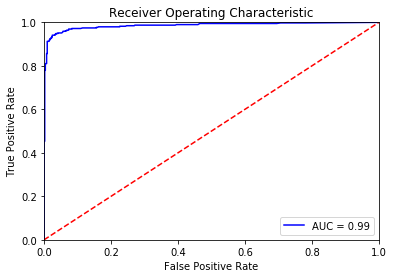

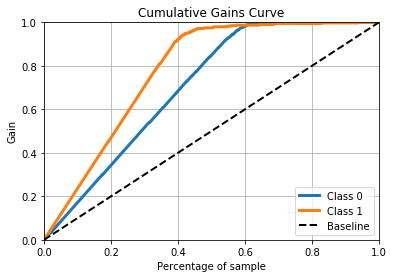

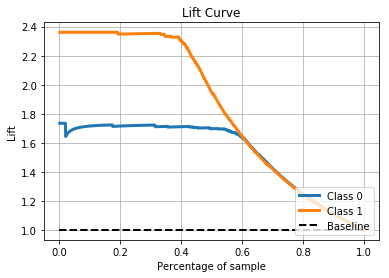

In [78]:
# Since RandomForest performed the best, we check its performance on the test data
models_param_grid = {
        'bootstrap': [True, False],
         'max_depth': [10, 20, 30, 40, 50,  100, None], # 60, 70, 80, 90,
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400, 600, 800, 1000]} # 1200, 1400, 1600, 1800, 2000
grid_clf = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=models_param_grid, cv=inner_cv, n_jobs = -1)
grid_clf.fit(x_train_trans,y_train)
print("Best Estimator\n:", grid_clf.best_estimator_)
print("Best Parameters:\n",grid_clf.best_params_)
print("Best Score:\n",grid_clf.best_score_)
prediction = grid_clf.predict(x_test_trans)
print('Accuracy Score: ',accuracy_score(prediction, y_test))
print('Confusion Matrix:\n',confusion_matrix(y_test, prediction))
print('Classfication Report: \n',classification_report(y_test, prediction))

# calculate the fpr and tpr for all thresholds of the classification
probs = grid_clf.predict_proba(x_test_trans)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, probs)

# lift curve
skplt.metrics.plot_lift_curve(y_test, probs)
plt.title('Lift Curve')
plt.show()